<a href="https://colab.research.google.com/github/Mohamed2519/awesome-computer-vision/blob/master/RSNA_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mohamed** **Yasser** 

### **Coursat.ai** (Computer vision course)

**RSNA_Pneumonia Classification**

## **Install libraries and upload data**

In [0]:
!pip3 install --upgrade --force-reinstall kaggle

In [0]:
! pip install -q kaggle

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from google.colab import files
files.upload()

In [0]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.65G/3.66G [01:09<00:00, 70.9MB/s]
100% 3.66G/3.66G [01:09<00:00, 56.2MB/s]


In [0]:
!ls

'GCP Credits Request Link - RSNA.txt'	  stage_2_detailed_class_info.csv
'kaggle (1).json'			  stage_2_sample_submission.csv
 kaggle.json				  stage_2_test_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_images
 sample_data				  stage_2_train_labels.csv


In [0]:
!unzip rsna-pneumonia-detection-challenge.zip

In [0]:
!pip install pydicom

## **Data Visualization**

In [0]:
import pydicom, numpy as np
import pandas as pd

In [0]:
train_dir = 'stage_2_train_images/'

In [0]:
df = pd.read_csv('stage_2_train_labels.csv')
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [0]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
len(df)

30227

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71a808ce48>,
      dtype=object)

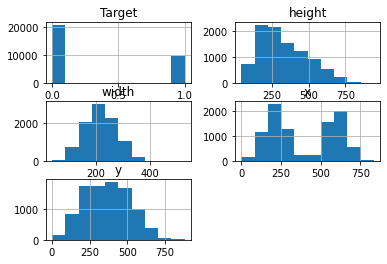

In [0]:
df.hist()

In [0]:
patientId = df['patientId'][3]
dcm_file = train_dir + '%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2293.1517874295.733882
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '003d8fa0-6bf1-40ed-b54c-ac657f8495c5'
(0010, 0020) Patient ID                          LO: '003d8fa0-6bf1-40ed-b54c-ac657f8495c5'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [0]:
len(df['Target'])

30227

In [0]:

im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


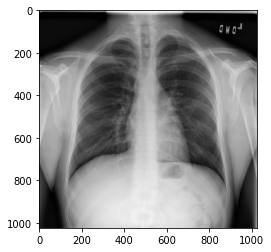

In [0]:

import matplotlib.pyplot as plt

plt.imshow(im, cmap=plt.cm.gist_gray)


In [0]:
def parse_data(df, parent_dir):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': parent_dir + '%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [0]:
parsed = parse_data(df, train_dir)

In [0]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])


{'dicom': 'stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


In [0]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

## Defected

In [0]:
df[df['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


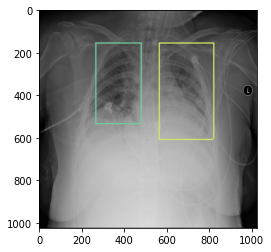

In [0]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

## Healthy

In [0]:
df[df['patientId'] == '0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0


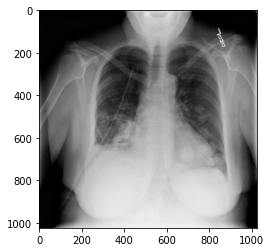

In [0]:
draw(parsed['0004cfab-14fd-4e49-80ba-63a80b6bddd6'])


## **Extracting Data and split it**

In [0]:
import cv2
x=[]
y=[]
for idx,pid in enumerate (parsed):
  d=parsed[pid]
  dd = pydicom.read_file(d['dicom'])
  img= dd.pixel_array
  label=d['label']
  img=cv2.resize(img,(150,150))
  x.append(img)
  y.append(label)
  #plt.imshow(img, cmap=plt.cm.gist_gray)
  
 

In [0]:

X=np.array(x)
Y=np.array(y)
X=X.reshape((26684,150,150,1))
X=X.astype('float32') / 255
X.shape

(26684, 150, 150, 1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val= train_test_split(X_train, Y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [0]:
X.shape

(26684, 150, 150, 1)

# **Building network** 

# **Model1**

## Without regularization

In [0]:
from keras import models,layers,regularizers
model_Without_reg = models.Sequential()
model_Without_reg.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(150, 150, 1)))
model_Without_reg.add(layers.MaxPooling2D((2, 2)))

model_Without_reg.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_Without_reg.add(layers.MaxPooling2D((2, 2)))

model_Without_reg.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_Without_reg.add(layers.MaxPooling2D((2, 2)))

model_Without_reg.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_Without_reg.add(layers.MaxPooling2D((2, 2)))

model_Without_reg.add(layers.Flatten())
model_Without_reg.add(layers.Dense(512, activation='relu'))
model_Without_reg.add(layers.Dense(1, activation='sigmoid'))

model_Without_reg.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 14, 14, 256)     

### Optimizer

In [0]:
from keras import optimizers

opt=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_Without_reg.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [0]:
training_history1=model_Without_reg.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=25, batch_size=32)

Train on 16010 samples, validate on 5337 samples
Epoch 1/25
16010/16010 [==============================] - 31s 2ms/step - loss: 0.0525 - acc: 0.9810 - val_loss: 1.8072 - val_acc: 0.7802
Epoch 2/25
16010/16010 [==============================] - 31s 2ms/step - loss: 0.0559 - acc: 0.9805 - val_loss: 2.0174 - val_acc: 0.7847
Epoch 3/25
16010/16010 [==============================] - 31s 2ms/step - loss: 0.0689 - acc: 0.9791 - val_loss: 1.4813 - val_acc: 0.7667
Epoch 4/25
16010/16010 [==============================] - 31s 2ms/step - loss: 0.0462 - acc: 0.9859 - val_loss: 2.1148 - val_acc: 0.7930
Epoch 5/25
16010/16010 [==============================] - 31s 2ms/step - loss: 0.0620 - acc: 0.9811 - val_loss: 1.8690 - val_acc: 0.7789
Epoch 6/25
16010/16010 [==============================] - 31s 2ms/step - loss: 0.0235 - acc: 0.9932 - val_loss: 2.0501 - val_acc: 0.7782
Epoch 7/25
16010/16010 [==============================] - 31s 2ms/step - loss: 0.0415 - acc: 0.9870 - val_loss: 1.9691 - val_acc:

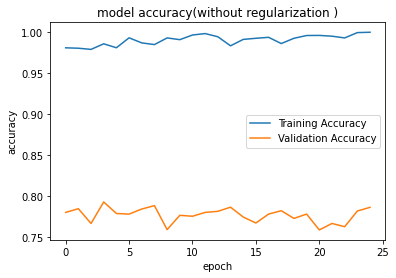

In [0]:
import matplotlib.pyplot as plt
plt.plot(training_history1.history['acc'],label='Training Accuracy')
plt.plot(training_history1.history['val_acc'],label='Validation Accuracy')
plt.title('model accuracy(without regularization )')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()


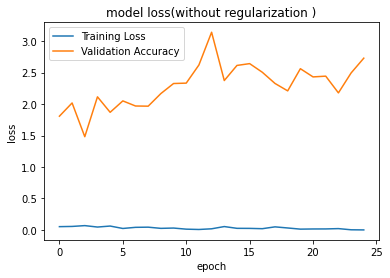

In [0]:
plt.plot(training_history1.history['loss'],label='Training Loss')
plt.plot(training_history1.history['val_loss'],label='Validation Accuracy')
plt.title('model loss(without regularization )')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


# **Model2**

## With regularization (L2 & Dropout)

In [0]:
from keras import models,layers,regularizers
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))


In [0]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 33, 33, 128)      

## Optimizer

In [0]:
from keras import optimizers

opt=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [0]:
training_history=model2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=25, batch_size=32)

Train on 16010 samples, validate on 5337 samples
Epoch 1/25
16010/16010 [==============================] - 36s 2ms/step - loss: 0.5691 - acc: 0.7843 - val_loss: 0.4762 - val_acc: 0.7875
Epoch 2/25
16010/16010 [==============================] - 36s 2ms/step - loss: 0.4457 - acc: 0.7964 - val_loss: 0.4597 - val_acc: 0.7971
Epoch 3/25
16010/16010 [==============================] - 36s 2ms/step - loss: 0.4404 - acc: 0.8027 - val_loss: 0.4698 - val_acc: 0.8023
Epoch 4/25
16010/16010 [==============================] - 36s 2ms/step - loss: 0.4380 - acc: 0.8031 - val_loss: 0.4617 - val_acc: 0.8029
Epoch 5/25
16010/16010 [==============================] - 35s 2ms/step - loss: 0.4364 - acc: 0.8041 - val_loss: 0.4715 - val_acc: 0.7988
Epoch 6/25
16010/16010 [==============================] - 35s 2ms/step - loss: 0.4358 - acc: 0.8048 - val_loss: 0.4755 - val_acc: 0.7967
Epoch 7/25
16010/16010 [==============================] - 35s 2ms/step - loss: 0.4316 - acc: 0.8056 - val_loss: 0.4564 - val_acc:

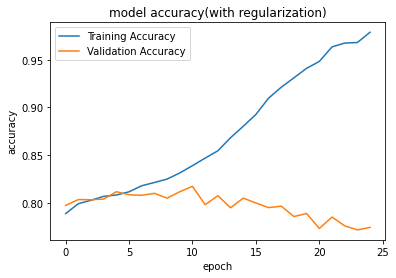

In [0]:
import matplotlib.pyplot as plt
plt.plot(training_history.history['acc'],label='Training Accuracy')
plt.plot(training_history.history['val_acc'],label='Validation Accuracy')
plt.title('model accuracy(with regularization)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()


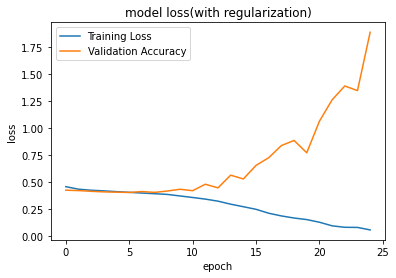

In [0]:
plt.plot(training_history2.history['loss'],label='Training Loss')
plt.plot(training_history2.history['val_loss'],label='Validation Accuracy')
plt.title('model loss(with regularization)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


# **Model3**

## **Apply K-fold Cross Validation**

In [0]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

opt=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model3.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [0]:
from sklearn.model_selection import KFold

# Model configuration
batch_size = 32
no_epochs = 20
validation_split = 0.2
num_folds = 5

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = X_train
targets = Y_train

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history3 = model3.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,validation_split=validation_split)

  # Generate generalization metrics
  scores = model3.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model3.metrics_names[0]} of {scores[0]}; {model3.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')


------------------------------------------------------------------------
Training for fold 1 ...
Train on 13661 samples, validate on 3416 samples
Epoch 1/20
13661/13661 [==============================] - 31s 2ms/step - loss: 0.5827 - acc: 0.7775 - val_loss: 0.5843 - val_acc: 0.7617
Epoch 2/20
13661/13661 [==============================] - 30s 2ms/step - loss: 0.4479 - acc: 0.7924 - val_loss: 0.4798 - val_acc: 0.7787
Epoch 3/20
13661/13661 [==============================] - 30s 2ms/step - loss: 0.4417 - acc: 0.7983 - val_loss: 0.4688 - val_acc: 0.7904
Epoch 4/20
13661/13661 [==============================] - 30s 2ms/step - loss: 0.4395 - acc: 0.8016 - val_loss: 0.4880 - val_acc: 0.7951
Epoch 5/20
13661/13661 [==============================] - 29s 2ms/step - loss: 0.4366 - acc: 0.8038 - val_loss: 0.4725 - val_acc: 0.7907
Epoch 6/20
13661/13661 [==============================] - 29s 2ms/step - loss: 0.4285 - acc: 0.8079 - val_loss: 0.4600 - val_acc: 0.7889
Epoch 7/20
13661/13661 [========

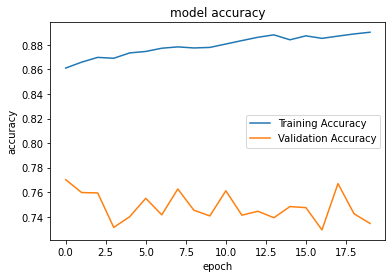

In [0]:
import matplotlib.pyplot as plt
plt.plot(history3.history['acc'],label='Training Accuracy')
plt.plot(history3.history['val_acc'],label='Validation Accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()


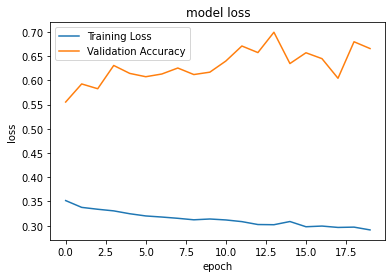

In [0]:
plt.plot(history3.history['loss'],label='Training Loss')
plt.plot(history3.history['val_loss'],label='Validation Accuracy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


In [0]:
model_Without_reg.save('drive/My Drive/RSNA_Pneumonia1.h5')
model.save('drive/My Drive/RSNA_Pneumonia2.h5')
model3.save('drive/My Drive/RSNA_Pneumonia3.h5')

# **Model4**

**Becouse of data imbalance(positive cases represent 20% of all data), Try to add class_weight**

In [0]:
from keras import models,layers,regularizers
from keras import optimizers

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

opt=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model4.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

Using TensorFlow backend.


In [0]:
training_history_class_weight=model4.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=25, batch_size=32,class_weight={1:0.8,0:0.2})

Train on 16010 samples, validate on 5337 samples
Epoch 1/25
16010/16010 [==============================] - 37s 2ms/step - loss: 0.1993 - acc: 0.6906 - val_loss: 0.8447 - val_acc: 0.4772
Epoch 2/25
16010/16010 [==============================] - 37s 2ms/step - loss: 0.1886 - acc: 0.7040 - val_loss: 0.7248 - val_acc: 0.6211
Epoch 3/25
16010/16010 [==============================] - 37s 2ms/step - loss: 0.1857 - acc: 0.7033 - val_loss: 0.7161 - val_acc: 0.6076
Epoch 4/25
16010/16010 [==============================] - 37s 2ms/step - loss: 0.1860 - acc: 0.7007 - val_loss: 0.6277 - val_acc: 0.6993
Epoch 5/25
16010/16010 [==============================] - 37s 2ms/step - loss: 0.1844 - acc: 0.7080 - val_loss: 0.6713 - val_acc: 0.6517
Epoch 6/25
16010/16010 [==============================] - 37s 2ms/step - loss: 0.1838 - acc: 0.7079 - val_loss: 0.7279 - val_acc: 0.5861
Epoch 7/25
16010/16010 [==============================] - 37s 2ms/step - loss: 0.1830 - acc: 0.6977 - val_loss: 0.6769 - val_acc:

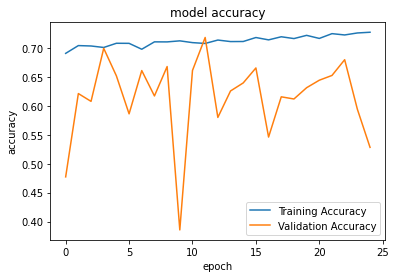

In [0]:
import matplotlib.pyplot as plt
plt.plot(training_history_class_weight.history['acc'],label='Training Accuracy')
plt.plot(training_history_class_weight.history['val_acc'],label='Validation Accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()


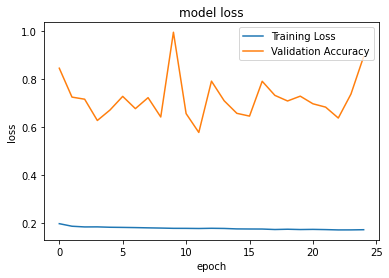

In [0]:
plt.plot(training_history_class_weight.history['loss'],label='Training Loss')
plt.plot(training_history_class_weight.history['val_loss'],label='Validation Accuracy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


# **Model5**

### **Minimize model complixty and use batch norm**

In [0]:
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(150, 150, 1)))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Flatten())
model5.add(layers.Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

opt=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model5.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])
model5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 146, 146, 32)      832       
_________________________________________________________________
batch_normalization_2 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 35, 35, 64)       

In [0]:
training_history_BN=model5.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=25, batch_size=32) #,class_weight={1:0.8,0:0.2})

Train on 16010 samples, validate on 5337 samples
Epoch 1/25
16010/16010 [==============================] - 75s 5ms/step - loss: 1.8793 - acc: 0.7758 - val_loss: 1.6837 - val_acc: 0.7767
Epoch 2/25
16010/16010 [==============================] - 74s 5ms/step - loss: 0.6402 - acc: 0.7944 - val_loss: 11.6424 - val_acc: 0.7768
Epoch 3/25
16010/16010 [==============================] - 74s 5ms/step - loss: 0.5229 - acc: 0.7993 - val_loss: 0.5884 - val_acc: 0.7991
Epoch 4/25
16010/16010 [==============================] - 74s 5ms/step - loss: 0.4754 - acc: 0.8034 - val_loss: 1.1247 - val_acc: 0.7787
Epoch 5/25
16010/16010 [==============================] - 74s 5ms/step - loss: 0.4587 - acc: 0.8043 - val_loss: 0.6599 - val_acc: 0.7890
Epoch 6/25
16010/16010 [==============================] - 74s 5ms/step - loss: 0.4506 - acc: 0.8077 - val_loss: 0.5224 - val_acc: 0.7883
Epoch 7/25
16010/16010 [==============================] - 74s 5ms/step - loss: 0.4424 - acc: 0.8126 - val_loss: 0.4361 - val_acc

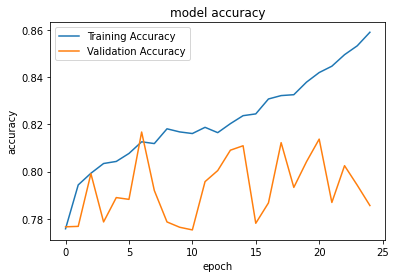

In [0]:
import matplotlib.pyplot as plt
plt.plot(training_history_BN.history['acc'],label='Training Accuracy')
plt.plot(training_history_BN.history['val_acc'],label='Validation Accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()


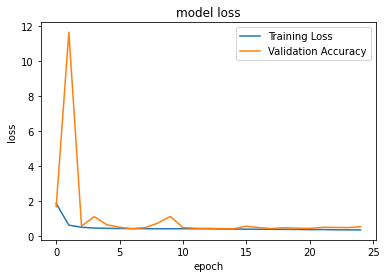

In [0]:
plt.plot(training_history_BN.history['loss'],label='Training Loss')
plt.plot(training_history_BN.history['val_loss'],label='Validation Accuracy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


# **Evaluate Model5**

In [0]:
scores = model5.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', scores[0]) 
print('Test accuracy:', scores[1])

Test loss: 0.5405748015779535
Test accuracy: 0.7884579300880432


In [0]:
model5.save('drive/My Drive/RSNA_Pneumonia5.h5')

# **Notes**

- Becouse of data imbalance there is a big overfitting. I tried to solve it by reduce model complixty , Add Regularization (dropout , L2, Batch Norm), Try to use weight class to pay more attention to positive cases ``(label 1)`` 
- the reason of didn't make Augumantation that input image must have its normal shape (there is no x-ray with flips or shear or even rotate)
-Next steps:
             - I'll try to use custom data generator to reduce memory usage
             - add more regularization 
             -try another model archtecture 

# **Custom Data Loader**

In [0]:
from keras.utils import Sequence

class rsna_dataset(Sequence):

  def __init__(self, data_path, batch_size=32, dim=(150,150)):
    self.img_dir=

    return
  def __len__(self):
    return

  def __getitem__(self,index):


    return

In [0]:
patientId = df['patientId'][3]
dcm_file = train_dir + '%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
im = dcm_data.pixel_array

In [0]:
pp=(os.listdir(train_dir))

In [0]:
pp[26683]

'f54cd24e-1464-46f4-b8b3-3e6946ae2584.dcm'

In [0]:
'0004cfab-14fd-4e49-80ba-63a80b6bddd6'-'%s.dcm' % patientId

In [0]:
from keras.utils import Sequence
class CAMVID_Dataset(Sequence):


    def __init__(self, images_dir, batch_size=4, dim=(150,150), n_classes=32, data_type='train', shape='normal'):

        self.images_dir =images_dir # str(data_path) + '/' + data_type + '/'
        self.masks_dir = str(data_path) + '/' + data_type + '_labels/'
        assert len(os.listdir(self.images_dir)) == len(os.listdir(self.masks_dir))
        self.data_type = data_type
        self.shape = shape
        self.batch_size = batch_size
        self.dim = dim
        self.n = len(os.listdir(self.images_dir))
        self.n_batches = int(np.floor(self.n  / self.batch_size))
        self.indexes = np.arange(self.n)

    def __len__(self):
        return  self.n_batches

    def __getitem__(self, index):
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.zeros((self.batch_size, *self.dim, n_classes))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Generate data
        for i, ID in enumerate(indexes):
          idx = ID

          file = sorted(os.listdir(self.images_dir))[idx]

          # Load image
          pydicom.read_file(images_dir).pixel_array
          image = np.array( pydicom.read_file(images_dir).pixel_array b+ file, target_size=(150,150)))*1./255


      
        return X, Y
      

In [0]:
dff = pd.read_csv('stage_2_train_labels.csv')


In [0]:
dff.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
